## Description:
######Model type = LSTM
######Hidden layers = 128*2
######train seq_len = 50
######model id = lstm128-10


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [14]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Data Loading

In [15]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 50
batch_size = 50
#model:
hidden_size = 128
n_layers = 2
#traininng:
n_epoch = 15
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "lstm128-50-test" #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"

Preprocessing Data

In [17]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

1706 torch.Size([51, 50])
87 torch.Size([51, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, n_seq=1, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    ridx = np.random.randint(0, len(data))
    batch_tensor = data[ridx]
    l = np.random.randint(0, batch_tensor.size(1)-n_seq)
    r = l+n_seq
    correct_predictions = 0.0
    total = 0.0
    hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
    input_variable = Variable(batch_tensor[:-1][l:r]).to(device)
    target_variable = Variable(batch_tensor[1:][l:r]).to(device)
    output, _ = model(input_variable, hidden)
    output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
    _, predicted = torch.max(output.data, 1)
    #print(batch_tensor.size())
    print(tensor2s(batch_tensor.transpose_(0,1)[0]))
    print(tensor2s(predicted))
    total += predicted.size(0)
    correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

Test Functionality

In [40]:
def test_model(cell_type="rnn", device='cpu'):
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=10, device=device))
    print("test random train seq")
    random_train_seq(model, test_data, n_seq=1, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([51, 50, 67]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.013920556753873825
test random train seq
torch.Size([51, 50])
ong the high tides in the calendar?
Nay, rather tur
YZvFZve.vevP!v:PdeH!HDevK H DvZvvzVeEA wtg.Dv]edSe
test generate with forwardc
Julietu!A!F ZXM OO ZQs:Svsd!FiPlQ;u!Kv3YGDQFuV.Id. dR nSNWxM OQ ZsDQ:QlQHO-uN&.OXusSS.PdqsDQFuV.TtIdqwNvvhmv:hvsDXws!:c:O:y]O. -QNv:OvsHv-uYKSiV&.O3EDQ:Q.Q  

testing lstm model
test forward
torch.Size([51, 50, 67]) torch.Size([2, 50, 128]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128]) torch.Size([2, 1, 128])
test cal_accuracy
0.0015200000489130616
test random train seq
torch.Size([51, 50])
Or madly think a babe of clouts were he:
I am not m
HJ[DCjWDW[JHHDDDD[DDWjDDHJJWJHDDDDDHD[WWWDWDD[W[JW
test generate with forwardc
JulietWJJ
D

DWDTTvTCTDvTDTCTvTTvTJD
DTCKTDTWDDDTJTCJ

DDDWDvDTvTTvDTDDvvJJJ
DDDJJJ




DcWD

Train

Build new model

In [21]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train()
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            model.eval()
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [25]:
train()

  0%|          | 0/1706 [00:00<?, ?it/s, loss=2.321, test_ac=0.347, train_ac=0.341]


At 1 epoche, loss = 2.731, train ac = 0.268, test ac = 0.269
RNN write with seed Juliet

##############################

Juliet' ary erante
Whes miscesl, gorn uy fale the thle' dotheny that as fuve he wins rgeit.

LFLOTENS:
Bathe tye congy thus not oo mokt ond the me bent me w

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=2.098, test_ac=0.377, train_ac=0.404]


At 2 epoche, loss = 2.197, train ac = 0.378, test ac = 0.382
RNN write with seed Juliet

##############################

Julietreach to vith woll doue marin, makle tours to so woith maon.

WENCTCOGES:
I I your ines,
Wher linle mact: the to pracs wiath streat of this, tide's th

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.934, test_ac=0.423, train_ac=0.441]


At 3 epoche, loss = 2.035, train ac = 0.410, test ac = 0.400
RNN write with seed Juliet

##############################

Julieto
the silf Gove man betanes: yustroas that here,
Teave not your hicled, the beech.

BABNIBAO:
Tay holcestes.

SPOLUKU:
By forly proobious to
That hat-

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.921, test_ac=0.409, train_ac=0.442]


At 4 epoche, loss = 1.976, train ac = 0.423, test ac = 0.423
RNN write with seed Juliet

##############################

Juliet,,
Thy bentance for and find not the beeps, in the growes, thou come come's time then viinter to wime and I thy bet and many
ming wourd, and besided:


##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.893, test_ac=0.446, train_ac=0.438]


At 5 epoche, loss = 1.901, train ac = 0.441, test ac = 0.433
RNN write with seed Juliet

##############################

Julietabon
Comte, I hear you unoles so pusfient in thy prictig thou am so wild Cansced.

EANTON:
I thene me thou love mandem?

TOLLANR:
God, and and such be

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.916, test_ac=0.426, train_ac=0.446]


At 6 epoche, loss = 1.869, train ac = 0.448, test ac = 0.442
RNN write with seed Juliet

##############################

Julietnes.

CARDAS:
Whells'd felless thirg?

KING GIUM:
Hither?

ORATLOUN:
I is I strevignly herses, the dies, this haves with the diving-rid
The srever but

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.757, test_ac=0.476, train_ac=0.470]


At 7 epoche, loss = 1.835, train ac = 0.459, test ac = 0.455
RNN write with seed Juliet

##############################

Julieter out cousinsy now,
They good so was it were your his hath horside.

WOLTA:
This say hone, and the gaull, and are must sisters, that a perceeves good

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.798, test_ac=0.458, train_ac=0.471]


At 8 epoche, loss = 1.816, train ac = 0.465, test ac = 0.460
RNN write with seed Juliet

##############################

Julieter's well,
Here had shall sworm, would my bock; be of in a man's sown of a fear the cun and sir,
I know a word he your loves in the gradewn your ark.


##############################



  1%|          | 10/1706 [00:00<00:17, 98.92it/s, loss=1.852, test_ac=0.470, train_ac=0.434]


At 9 epoche, loss = 1.769, train ac = 0.477, test ac = 0.464
RNN write with seed Juliet

##############################

Juliet, jidest,
As call if sounstare thee,
Trake my exculs at be eyes mark to pretire
To are me timenams so death to heart
so menry dead make to well.

COCH

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.762, test_ac=0.484, train_ac=0.483]


At 10 epoche, loss = 1.759, train ac = 0.474, test ac = 0.462
RNN write with seed Juliet

##############################

Juliet, hus, have his up him,
Be, your store in this dear the word of the soor,
I not desince comes of the own decles the fapper my gals.

KING GENRY VIIII:

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.766, test_ac=0.450, train_ac=0.480]


At 11 epoche, loss = 1.748, train ac = 0.480, test ac = 0.466
RNN write with seed Juliet

##############################

Julietor:
Way daster they lose in as apace of murse the prot, hein love broble,
Thy queesing to such we better the stame, and brew the vinisicy's abter.

DU

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.773, test_ac=0.474, train_ac=0.484]


At 12 epoche, loss = 1.722, train ac = 0.487, test ac = 0.473
RNN write with seed Juliet

##############################

Julieter of nothing, with hose.

CARNIS:
Give, it have the dought
We redevite I know about not be the wits:
And to mine too yet seem of calt man fire of the

##############################



  0%|          | 0/1706 [00:00<?, ?it/s, loss=1.562, test_ac=0.484, train_ac=0.555]


At 13 epoche, loss = 1.729, train ac = 0.490, test ac = 0.471
RNN write with seed Juliet

##############################

Julieter, I seak the refuil and
thus and well a nedio of consubles holving bring
your shallad be their fear-truth the bre'st their heart.

AMINIUS:
A are to

##############################



  1%|          | 10/1706 [00:00<00:17, 99.36it/s, loss=1.679, test_ac=0.478, train_ac=0.494]


At 14 epoche, loss = 1.682, train ac = 0.500, test ac = 0.480
RNN write with seed Juliet

##############################

Julieter; 'tis timen.

SEDENAR:
You sack Slieve him our curse
For thing fair and so my send in the tanders and moging and cincer?
Or Forth life, this canst 

##############################



100%|██████████| 1706/1706 [00:16<00:00, 106.11it/s, loss=1.756, test_ac=0.471, train_ac=0.484]



At 15 epoche, loss = 1.699, train ac = 0.496, test ac = 0.478
RNN write with seed Juliet

##############################

Julieter of I thank,
Which your kneed, I boy, Lessicious, through
honours he have with saidserous and bear
The tear nays, and when, who will grace.

KING RI

##############################

Tranning records saved to disk.


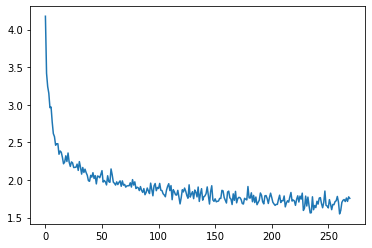

In [26]:
plt.figure()
plt.plot(record['loss'])
plt.show()

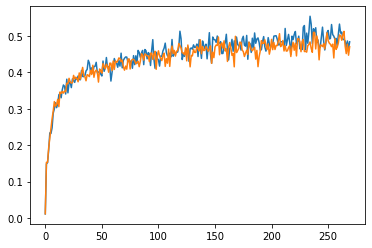

In [27]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [28]:
print(generate(model, device)) #default tau = 0.8

Julieter!

ROSALIN:
Ilf thou have inceive to thus.

Second Leda:
Is beflook shall can and think the cack on him fortune me wald
your poar fellow of the land


In [29]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

julieter of the stand of the stand of the stand of the stand of the stand of the stand of the stand of the stand of the stand of the stand of the stand of t 

juliet, MrispaCkidy
Croagzsipal Core
Asi, that,-Gnavion never'-lath?''rsibs frie'--non?, jows, besenst;
To hirts
UncH-fRAs dolitusanVy lowed
UnmAjEtm-w'stra 



In [30]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i willy.

TOMION:
Drave I serve my purse of my deserver of the worth
My am thow incouration and some her leates of picks not to the purses four trouch.

BOSTARD:
And I have hard the cuts, my lord lord,
Fissilance on of treather soth, thou with yet.

ANTIONA:
In well, he come to your kingmate,
To Jew the persawn: when he down by to his forsigly will not the
bay we comes discomel
In venty think him to have me; and taung and so lives
The liver, and it in his hibdy, that a an enement
Then the feast but hi 



In [31]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.49704185128211975

In [32]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n')

i willy against this fool
And your hungless of your what a puts; and good reck your highness,
With hath to priling to my brother my offer thought, being hour ards arch
more so your Taliance your hold of your highs.

PRINCENTIUS:
That assmence which a accike of shall auchings which this boudon,
He sup his daughters and fear of can here,
And rick underful to strange and person that have a world,
And pink with thy appraoch'd,
Thou art araming to me, thou ought, that he made both I vietion;
When they love 



In [33]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #honours

i willy break your cius fartter his it,
And with to the king of answer purosus to your honours
And fall mannatch inficed?

SIGO:
I Aupor to shall dear to most day.

ALANDO:
No, if the good stas:
As this shall soldizen'd the mome of her some starding's blood soul you
Can even master for thanks the war; which some chance exerured to
The could me sue, rast and gound,
Can the honoor I is him, 'ell defore cannot.

PORTIO:
My trust comes to the surus for so my did to he is me; and diner,
That mewnems of sta 

